# CNN Model Training for Brain Tumor Classification

This notebook trains a Convolutional Neural Network (CNN) to classify brain MRI images into 4 categories:
- **NO_TUMOR**: Healthy brain (no tumor detected)
- **GLIOMA**: Glioma tumor type
- **MENINGIOMA**: Meningioma tumor type
- **PITUITARY**: Pituitary tumor type

## Overview

This notebook includes:
1. Data loading and preprocessing
2. CNN model architecture definition
3. Training pipeline with validation
4. Comprehensive evaluation (confusion matrix, classification report)
5. Visualization of results (training curves, confusion matrix, sample predictions)
6. Model saving

## Requirements

Make sure you have installed all required packages:
```bash
pip install torch torchvision seaborn pandas scikit-learn matplotlib numpy tqdm
```

Or install from requirements.txt:
```bash
pip install -r requirements.txt
```

## 1. Initialization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import os
import random
from pathlib import Path

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Ti


## 2. Configuration

In [2]:
# Configuration
DATA_DIR = 'data/vgg16_classification'
MODEL_DIR = 'models/cnn'
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, 'cnn_brain_tumor_classifier.pth')
HISTORY_SAVE_PATH = os.path.join(MODEL_DIR, 'cnn_training_history.csv')

# Training hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
NUM_CLASSES = 4

# Class names
CLASS_NAMES = ['NO_TUMOR', 'GLIOMA', 'MENINGIOMA', 'PITUITARY']

# Create models directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

## 3. Custom Dataset Class Using CSV Metadata

In [3]:
# Custom dataset class that uses CSV metadata to prevent data leakage
from torch.utils.data import Dataset
from PIL import Image

class FilteredImageFolder(Dataset):
    """
    Custom dataset that loads images based on CSV metadata to prevent data leakage.
    Only loads images whose original_filename is NOT in other splits.
    """
    def __init__(self, metadata_df, split_name, transform=None, base_dir='data/vgg16_classification'):
        """
        Args:
            metadata_df: DataFrame with columns: image_path, full_path, class, split, filename, original_filename (optional)
            split_name: 'train', 'val', or 'test'
            transform: Image transforms
            base_dir: Base directory for images
        """
        self.split_name = split_name
        self.transform = transform
        self.base_dir = base_dir
        
        # Filter by split
        split_df = metadata_df[metadata_df['split'] == split_name].copy()
        
        # For train: use augmented metadata, filter by original_filename not in test/val
        if split_name == 'train':
            # Get original filenames from test and val splits (from original metadata)
            if 'original_filename' in metadata_df.columns:
                # This is augmented metadata
                orig_metadata_path = 'data/dataset_metadata.csv'
                if os.path.exists(orig_metadata_path):
                    orig_df = pd.read_csv(orig_metadata_path)
                    test_originals = set(orig_df[orig_df['split'] == 'test']['filename'].unique())
                    val_originals = set(orig_df[orig_df['split'] == 'val']['filename'].unique())
                    excluded_originals = test_originals.union(val_originals)
                    # Filter: only keep images whose original_filename is NOT in test/val
                    split_df = split_df[~split_df['original_filename'].isin(excluded_originals)]
        
        # For val/test: use original metadata, ensure no overlap with train
        elif split_name in ['val', 'test']:
            # Get train original filenames (from augmented metadata if available)
            aug_metadata_path = 'data/augmented_dataset_metadata.csv'
            if os.path.exists(aug_metadata_path):
                aug_df = pd.read_csv(aug_metadata_path)
                train_originals = set(aug_df[aug_df['split'] == 'train']['original_filename'].unique())
                # Filter: only keep images whose filename is NOT in train
                split_df = split_df[~split_df['filename'].isin(train_originals)]
        
        self.samples = []
        self.classes = sorted(split_df['class'].unique().tolist())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        for _, row in split_df.iterrows():
            # Use full_path if available, otherwise construct from base_dir and image_path
            if pd.notna(row.get('full_path')):
                img_path = row['full_path']
            else:
                img_path = os.path.join(base_dir, row['image_path'])
            
            # Normalize path separators
            img_path = img_path.replace('\\', '/')
            
            if os.path.exists(img_path):
                label = self.class_to_idx[row['class']]
                self.samples.append((img_path, label))
            else:
                print(f"Warning: Image not found: {img_path}")
        
        print(f"Loaded {len(self.samples)} images for {split_name} split (filtered from {len(split_df)} rows in CSV)")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


## 3. Data Loading and Preprocessing

In [4]:
# Data transforms
# Training: only normalization (augmentation already applied via augment_training_data.py)
# Use train_augmented directory which contains pre-augmented images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test: only normalization (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets using CSV metadata to prevent data leakage
print("Loading datasets using CSV metadata files to prevent data leakage...")

# #region agent log
import json
import time
LOG_PATH = '/home/benaaf/CSE465/Deep-MRIC/.cursor/debug.log'
def log_debug(location, message, data, hypothesis_id='A'):
    try:
        os.makedirs(os.path.dirname(LOG_PATH), exist_ok=True)
        with open(LOG_PATH, 'a') as f:
            log_entry = {
                'id': f'log_{int(time.time()*1000)}',
                'timestamp': int(time.time()*1000),
                'location': location,
                'message': message,
                'data': data,
                'sessionId': 'debug-session',
                'runId': 'post-fix',
                'hypothesisId': hypothesis_id
            }
            f.write(json.dumps(log_entry) + '\n')
    except Exception as e:
        print(f"Logging error: {e}")
# #endregion

# Load metadata CSV files
augmented_metadata_path = 'data/augmented_dataset_metadata.csv'
original_metadata_path = 'data/dataset_metadata.csv'

if os.path.exists(augmented_metadata_path):
    aug_metadata_df = pd.read_csv(augmented_metadata_path)
    print(f"Loaded augmented metadata: {len(aug_metadata_df)} rows")
else:
    print(f"Warning: {augmented_metadata_path} not found. Creating empty DataFrame.")
    aug_metadata_df = pd.DataFrame()

if os.path.exists(original_metadata_path):
    orig_metadata_df = pd.read_csv(original_metadata_path)
    print(f"Loaded original metadata: {len(orig_metadata_df)} rows")
else:
    print(f"Warning: {original_metadata_path} not found. Creating empty DataFrame.")
    orig_metadata_df = pd.DataFrame()

# Use FilteredImageFolder for train (from augmented metadata)
if len(aug_metadata_df) > 0:
    train_dataset = FilteredImageFolder(aug_metadata_df, 'train', transform=train_transform, base_dir=DATA_DIR)
else:
    print("Falling back to ImageFolder for train (no augmented metadata found)")
    train_dir = os.path.join(DATA_DIR, 'train_augmented')
    if not os.path.exists(train_dir):
        train_dir = os.path.join(DATA_DIR, 'train')
    train_dataset = ImageFolder(root=train_dir, transform=train_transform)

# Use FilteredImageFolder for val and test (from original metadata)
if len(orig_metadata_df) > 0:
    val_dataset = FilteredImageFolder(orig_metadata_df, 'val', transform=val_test_transform, base_dir=DATA_DIR)
    test_dataset = FilteredImageFolder(orig_metadata_df, 'test', transform=val_test_transform, base_dir=DATA_DIR)
else:
    print("Falling back to ImageFolder for val/test (no original metadata found)")
    val_dataset = ImageFolder(root=os.path.join(DATA_DIR, 'val'), transform=val_test_transform)
    test_dataset = ImageFolder(root=os.path.join(DATA_DIR, 'test'), transform=val_test_transform)

# #region agent log
# Verify no data leakage after filtering
def extract_original_filenames_from_dataset(dataset, split_name):
    """Extract original filenames from dataset samples"""
    original_filenames = set()
    for path, _ in dataset.samples:
        filename = os.path.basename(path)
        if '_aug' in filename:
            parts = filename.split('_aug')
            if len(parts) > 1:
                base = parts[0]
                ext = os.path.splitext(filename)[1]
                original_filename = base + ext
            else:
                original_filename = filename
        else:
            original_filename = filename
        original_filenames.add(original_filename)
    return original_filenames

train_originals = extract_original_filenames_from_dataset(train_dataset, 'train')
val_originals = extract_original_filenames_from_dataset(val_dataset, 'val')
test_originals = extract_original_filenames_from_dataset(test_dataset, 'test')

train_test_overlap = train_originals.intersection(test_originals)
train_val_overlap = train_originals.intersection(val_originals)
val_test_overlap = val_originals.intersection(test_originals)

log_debug('train_cnn.ipynb:9', 'Post-fix data leakage check', {
    'train_unique_originals': len(train_originals),
    'val_unique_originals': len(val_originals),
    'test_unique_originals': len(test_originals),
    'train_test_overlap_count': len(train_test_overlap),
    'train_val_overlap_count': len(train_val_overlap),
    'val_test_overlap_count': len(val_test_overlap),
    'has_data_leakage': len(train_test_overlap) > 0,
    'using_csv_metadata': True,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'test_samples': len(test_dataset)
}, 'B')
# #endregion

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f'\nTrain samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Class names: {train_dataset.classes}')

if train_test_overlap:
    print(f'\n  WARNING: Still found {len(train_test_overlap)} overlapping files between train and test!')
else:
    print(f'\n SUCCESS: No data leakage detected! Train and test sets are properly separated.')

Loading datasets using CSV metadata files to prevent data leakage...
Loaded augmented metadata: 58992 rows
Loaded original metadata: 7023 rows
Loaded 22488 images for train split (filtered from 22488 rows in CSV)
Loaded 93 images for val split (filtered from 93 rows in CSV)
Loaded 75 images for test split (filtered from 75 rows in CSV)

Train samples: 22488
Validation samples: 93
Test samples: 75
Number of classes: 4
Class names: ['GLIOMA', 'MENINGIOMA', 'NO_TUMOR', 'PITUITARY']

 SUCCESS: No data leakage detected! Train and test sets are properly separated.


### 3.1 Class Distribution

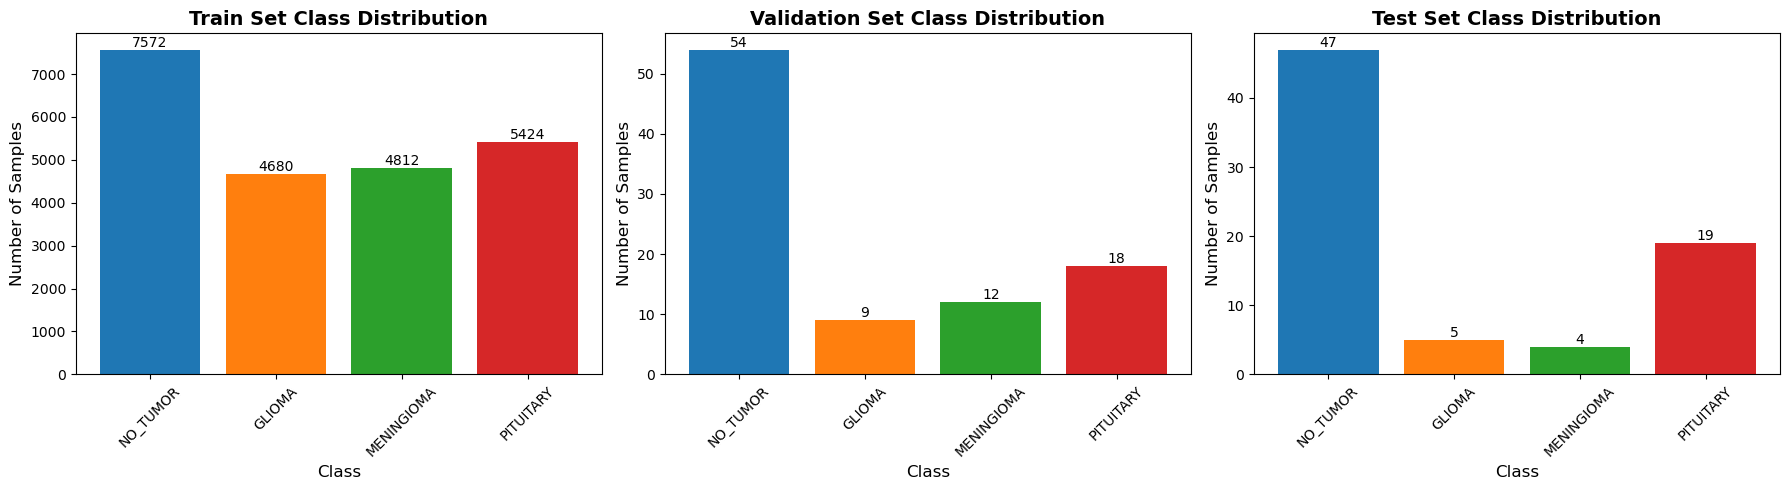


Class Distribution Summary:
Class           Train      Val        Test      
--------------------------------------------------
NO_TUMOR        7572       54         47        
GLIOMA          4680       9          5         
MENINGIOMA      4812       12         4         
PITUITARY       5424       18         19        


In [5]:
# Display class distribution
def get_class_distribution(dataset):
    class_counts = {}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

train_dist = get_class_distribution(train_dataset)
val_dist = get_class_distribution(val_dataset)
test_dist = get_class_distribution(test_dataset)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (dist, title) in enumerate([(train_dist, 'Train'), (val_dist, 'Validation'), (test_dist, 'Test')]):
    classes = list(dist.keys())
    counts = list(dist.values())
    axes[idx].bar(classes, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[idx].set_title(f'{title} Set Class Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Class', fontsize=12)
    axes[idx].set_ylabel('Number of Samples', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    for i, v in enumerate(counts):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary
print("\nClass Distribution Summary:")
print(f"{'Class':<15} {'Train':<10} {'Val':<10} {'Test':<10}")
print("-" * 50)
for class_name in CLASS_NAMES:
    print(f"{class_name:<15} {train_dist.get(class_name, 0):<10} {val_dist.get(class_name, 0):<10} {test_dist.get(class_name, 0):<10}")

## 4. CNN Model Architecture

In [6]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize model
model = BrainTumorCNN(num_classes=NUM_CLASSES).to(device)

# Print model architecture
print("CNN Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

CNN Model Architecture:
BrainTumorCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

## 5. Training Configuration

In [7]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Learning rate scheduler: ReduceLROnPlateau")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Learning rate scheduler: ReduceLROnPlateau


## 6. Training Loop

In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [9]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0
early_stopping_patience = 10

print("Starting training...")
print(f"Training for {NUM_EPOCHS} epochs")
print("-" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'history': history
        }, MODEL_SAVE_PATH)
        print(f"Saved best model (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "=" * 60)
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training...
Training for 50 epochs
------------------------------------------------------------

Epoch 1/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.27it/s]


Train Loss: 0.7898, Train Acc: 68.38%
Val Loss: 0.5984, Val Acc: 81.72%
Learning Rate: 0.001000
Saved best model (Val Acc: 81.72%)

Epoch 2/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.66it/s]


Train Loss: 0.4960, Train Acc: 81.19%
Val Loss: 0.2369, Val Acc: 89.25%
Learning Rate: 0.001000
Saved best model (Val Acc: 89.25%)

Epoch 3/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.60it/s]


Train Loss: 0.3739, Train Acc: 86.40%
Val Loss: 0.8740, Val Acc: 81.72%
Learning Rate: 0.001000

Epoch 4/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.58it/s]


Train Loss: 0.2992, Train Acc: 89.29%
Val Loss: 0.3574, Val Acc: 86.02%
Learning Rate: 0.001000

Epoch 5/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.57it/s]


Train Loss: 0.2365, Train Acc: 91.51%
Val Loss: 0.1711, Val Acc: 95.70%
Learning Rate: 0.001000
Saved best model (Val Acc: 95.70%)

Epoch 6/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.30it/s]


Train Loss: 0.1914, Train Acc: 93.39%
Val Loss: 0.1930, Val Acc: 93.55%
Learning Rate: 0.001000

Epoch 7/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.31it/s]


Train Loss: 0.1511, Train Acc: 94.92%
Val Loss: 0.5422, Val Acc: 84.95%
Learning Rate: 0.001000

Epoch 8/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.35it/s]


Train Loss: 0.1274, Train Acc: 95.67%
Val Loss: 0.3124, Val Acc: 93.55%
Learning Rate: 0.001000

Epoch 9/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.35it/s]


Train Loss: 0.1118, Train Acc: 96.22%
Val Loss: 0.0955, Val Acc: 97.85%
Learning Rate: 0.001000
Saved best model (Val Acc: 97.85%)

Epoch 10/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.67it/s]


Train Loss: 0.0937, Train Acc: 96.80%
Val Loss: 0.1744, Val Acc: 93.55%
Learning Rate: 0.001000

Epoch 11/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.62it/s]


Train Loss: 0.0851, Train Acc: 97.00%
Val Loss: 0.1501, Val Acc: 95.70%
Learning Rate: 0.001000

Epoch 12/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.22it/s]


Train Loss: 0.0696, Train Acc: 97.82%
Val Loss: 0.0819, Val Acc: 98.92%
Learning Rate: 0.001000
Saved best model (Val Acc: 98.92%)

Epoch 13/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.51it/s]


Train Loss: 0.0653, Train Acc: 97.73%
Val Loss: 0.1915, Val Acc: 94.62%
Learning Rate: 0.001000

Epoch 14/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.59it/s]


Train Loss: 0.0589, Train Acc: 98.08%
Val Loss: 0.3226, Val Acc: 92.47%
Learning Rate: 0.001000

Epoch 15/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.64it/s]


Train Loss: 0.0521, Train Acc: 98.25%
Val Loss: 0.2371, Val Acc: 94.62%
Learning Rate: 0.001000

Epoch 16/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.38it/s]


Train Loss: 0.0461, Train Acc: 98.43%
Val Loss: 0.1299, Val Acc: 95.70%
Learning Rate: 0.001000

Epoch 17/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.48it/s]


Train Loss: 0.0414, Train Acc: 98.56%
Val Loss: 0.2732, Val Acc: 95.70%
Learning Rate: 0.001000

Epoch 18/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.35it/s]


Train Loss: 0.0438, Train Acc: 98.48%
Val Loss: 0.3275, Val Acc: 91.40%
Learning Rate: 0.000500

Epoch 19/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.23it/s]


Train Loss: 0.0173, Train Acc: 99.52%
Val Loss: 0.1328, Val Acc: 96.77%
Learning Rate: 0.000500

Epoch 20/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 10.57it/s]


Train Loss: 0.0122, Train Acc: 99.57%
Val Loss: 0.0794, Val Acc: 97.85%
Learning Rate: 0.000500

Epoch 21/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 11.17it/s]


Train Loss: 0.0190, Train Acc: 99.41%
Val Loss: 0.1531, Val Acc: 95.70%
Learning Rate: 0.000500

Epoch 22/50


Validating: 100%|██████████| 3/3 [00:00<00:00, 10.48it/s]

Train Loss: 0.0167, Train Acc: 99.42%
Val Loss: 0.0973, Val Acc: 96.77%
Learning Rate: 0.000500

Early stopping triggered after 22 epochs

Training completed!
Best validation accuracy: 98.92%


### 6.1 Save Training History

In [10]:
# Save training history to CSV
history_df = pd.DataFrame(history)
history_df.to_csv(HISTORY_SAVE_PATH, index=False)
print(f"Training history saved to {HISTORY_SAVE_PATH}")

Training history saved to models/cnn/cnn_training_history.csv


## 7. Training Curves Visualization

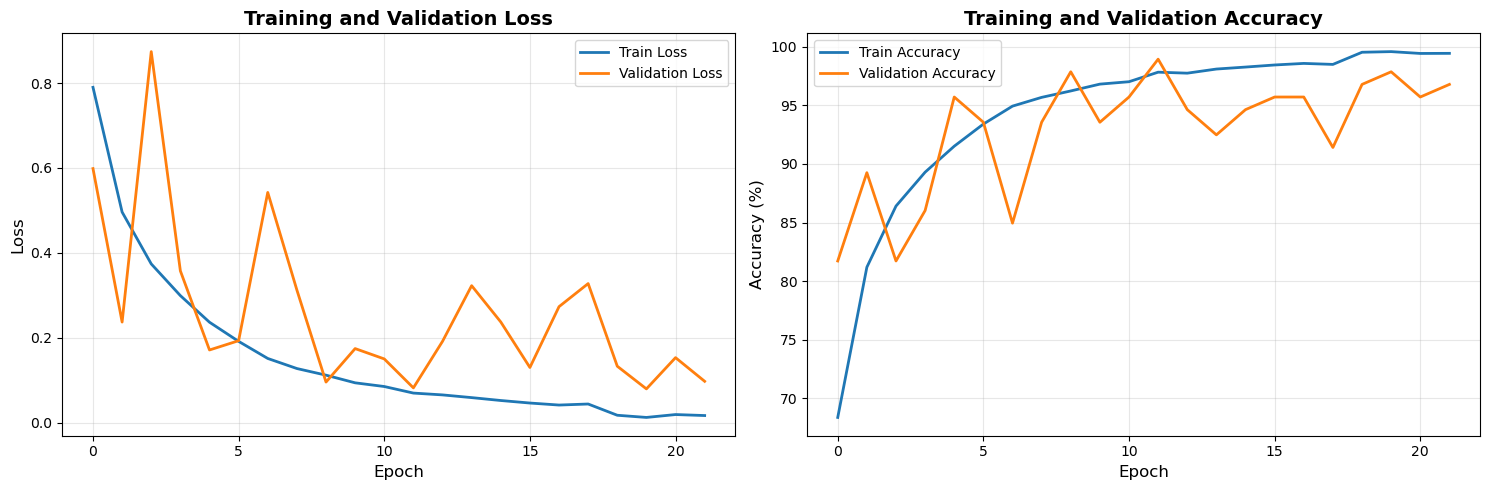

In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'cnn_training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

## 8. Load Best Model and Evaluate on Test Set

In [12]:
# Load best model
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Define y_true and y_pred for evaluation
y_true = all_labels
y_pred = all_preds

# Calculate and print overall accuracy score
accuracy = accuracy_score(y_true, y_pred)

# #region agent log
log_debug('train_cnn.ipynb:23', 'Test accuracy calculation', {
    'accuracy': float(accuracy),
    'accuracy_percent': float(accuracy * 100),
    'total_samples': len(y_true),
    'correct_predictions': sum(1 for i in range(len(y_true)) if y_true[i] == y_pred[i]),
    'incorrect_predictions': sum(1 for i in range(len(y_true)) if y_true[i] != y_pred[i]),
    'y_true_sample': y_true[:10],
    'y_pred_sample': y_pred[:10]
}, 'D')
# #endregion

print(f"\nOverall Accuracy Score: {accuracy:.4f} ({accuracy*100:.2f}%)")

Loaded best model from epoch 30
Best validation accuracy: 98.39%


Testing: 100%|██████████| 3/3 [00:00<00:00, 12.44it/s]

Logging error: Object of type int64 is not JSON serializable

Overall Accuracy Score: 0.9867 (98.67%)


## 9. Confusion Matrix

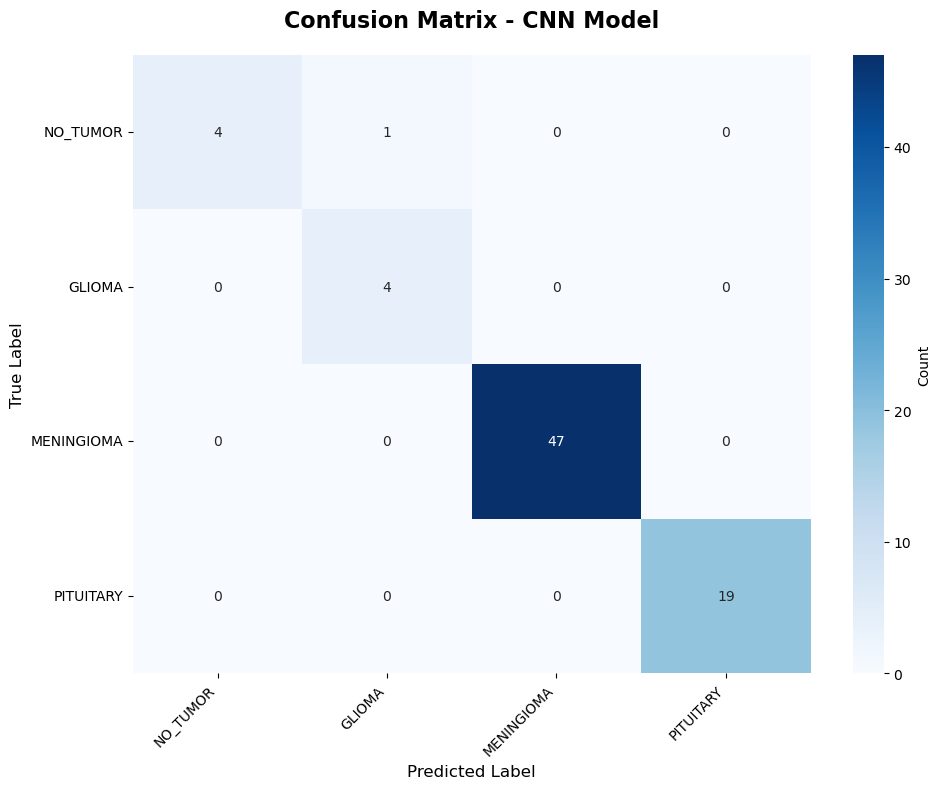


Confusion Matrix:
               NO_TUMOR       GLIOMA         MENINGIOMA     PITUITARY      
NO_TUMOR       4              1              0              0              
GLIOMA         0              4              0              0              
MENINGIOMA     0              0              47             0              
PITUITARY      0              0              0              19             


In [13]:
# Generate confusion matrix using y_true and y_pred
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - CNN Model', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'cnn_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print confusion matrix as table
print("\nConfusion Matrix:")
print(f"{'':<15}", end='')
for name in CLASS_NAMES:
    print(f"{name:<15}", end='')
print()
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:<15}", end='')
    for j in range(len(CLASS_NAMES)):
        print(f"{cm[i][j]:<15}", end='')
    print()

## 10. Classification Report

In [14]:
# Calculate and print the full classification report (showing precision, recall, and f1-score for all classes)
print("Full Classification Report:")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
print("=" * 70)

# Also generate report as dictionary for detailed access
report = classification_report(y_true, y_pred, 
                                target_names=CLASS_NAMES, 
                                output_dict=True)

print("Classification Report:")
print("=" * 70)
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)

for class_name in CLASS_NAMES:
    metrics = report[class_name]
    print(f"{class_name:<15} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} "
          f"{metrics['f1-score']:<12.4f} {int(metrics['support']):<10}")

print("-" * 70)
print(f"{'Accuracy':<15} {'':<12} {'':<12} {report['accuracy']:<12.4f} {len(y_true):<10}")
print(f"{'Macro Avg':<15} {report['macro avg']['precision']:<12.4f} "
      f"{report['macro avg']['recall']:<12.4f} {report['macro avg']['f1-score']:<12.4f} "
      f"{int(report['macro avg']['support']):<10}")
print(f"{'Weighted Avg':<15} {report['weighted avg']['precision']:<12.4f} "
      f"{report['weighted avg']['recall']:<12.4f} {report['weighted avg']['f1-score']:<12.4f} "
      f"{int(report['weighted avg']['support']):<10}")
print("=" * 70)

# Save report to file
report_path = os.path.join(MODEL_DIR, 'cnn_classification_report.txt')
with open(report_path, 'w') as f:
    f.write(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
print(f"\nClassification report saved to {report_path}")

Full Classification Report:
              precision    recall  f1-score   support

    NO_TUMOR       1.00      0.80      0.89         5
      GLIOMA       0.80      1.00      0.89         4
  MENINGIOMA       1.00      1.00      1.00        47
   PITUITARY       1.00      1.00      1.00        19

    accuracy                           0.99        75
   macro avg       0.95      0.95      0.94        75
weighted avg       0.99      0.99      0.99        75

Classification Report:
Class           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
NO_TUMOR        1.0000       0.8000       0.8889       5         
GLIOMA          0.8000       1.0000       0.8889       4         
MENINGIOMA      1.0000       1.0000       1.0000       47        
PITUITARY       1.0000       1.0000       1.0000       19        
----------------------------------------------------------------------
Accuracy                                  

## 11. Sample Predictions Visualization

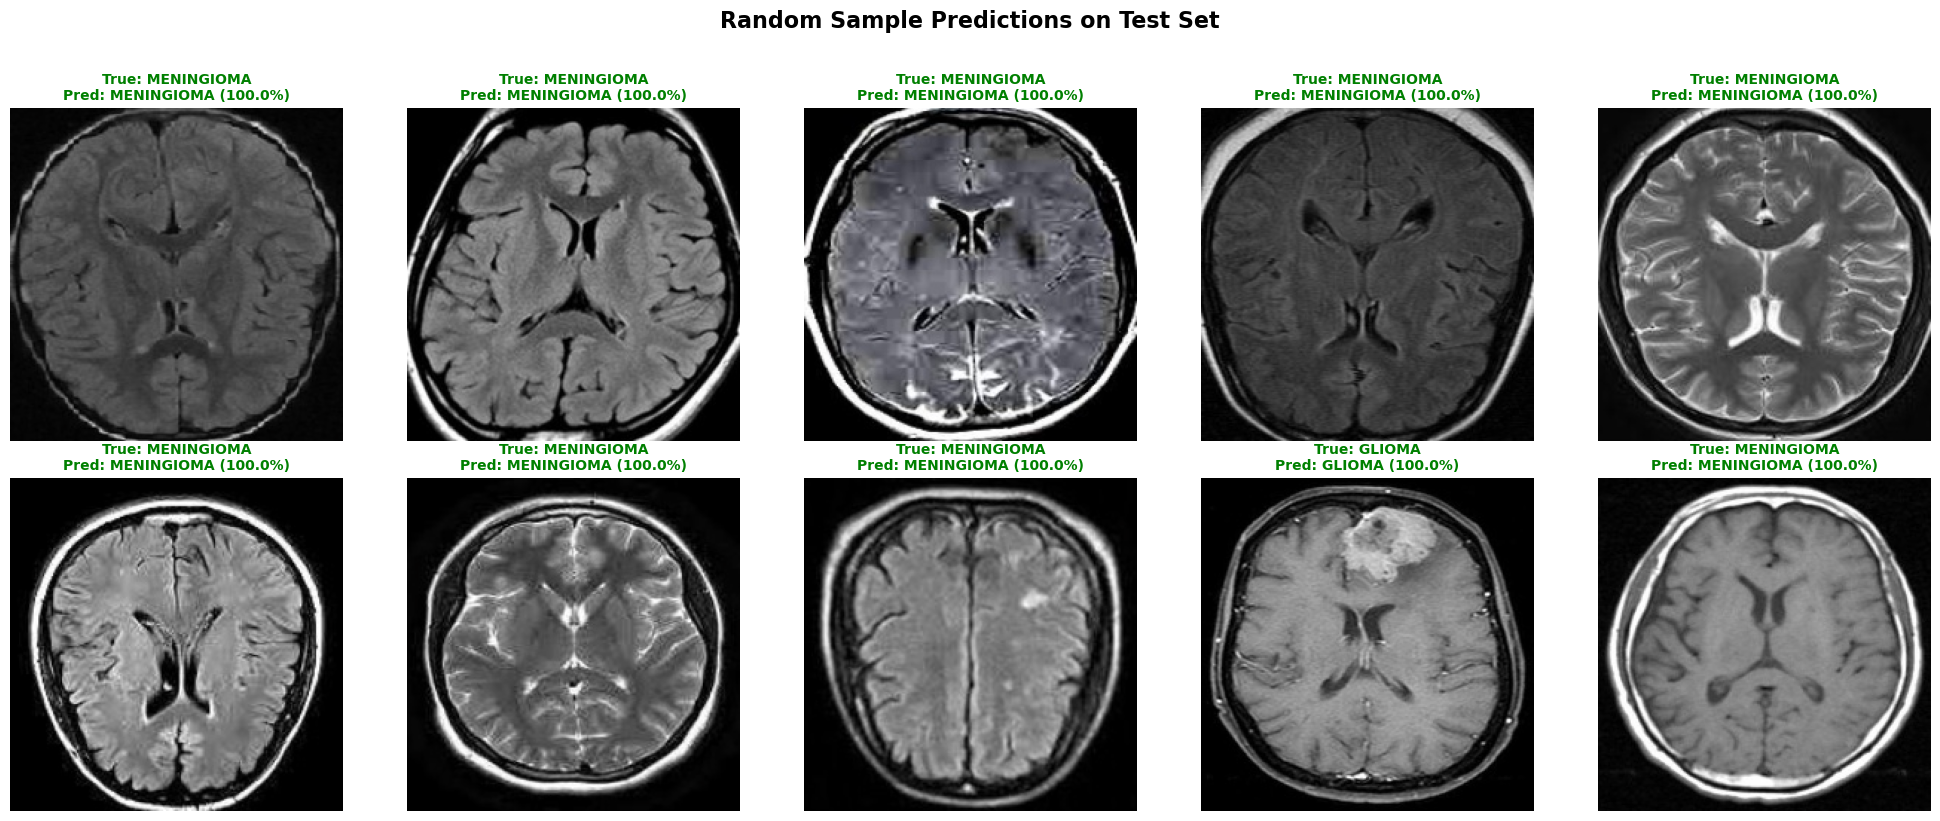

In [15]:
import random
import torch
import matplotlib.pyplot as plt

# -----------------------------
# RANDOM SAMPLE VISUALIZATION
# -----------------------------

model.eval()
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

# ---- STEP 1: Randomly pick 10 test samples ----
# This avoids the issue of showing only the first batch.
indices = random.sample(range(len(test_dataset)), 10)

images_list = []
labels_list = []

for idx in indices:
    img, label = test_dataset[idx]  # get one sample
    images_list.append(img)
    labels_list.append(label)

# Convert lists to tensors
images = torch.stack(images_list).to(device)
labels = torch.tensor(labels_list).to(device)

# ---- STEP 2: Run model prediction ----
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

# ---- STEP 3: Denormalize images for visualization ----
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for idx in range(10):
    img = images[idx].cpu()

    # Undo normalization so images look normal
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    
    # Convert tensor to numpy for matplotlib
    img = img.permute(1, 2, 0).numpy()
    
    # True & predicted labels
    true_label = CLASS_NAMES[labels[idx].item()]
    pred_label = CLASS_NAMES[predicted[idx].item()]
    confidence = probabilities[idx][predicted[idx]].item() * 100
    
    # Title color: green if correct, red if wrong
    color = 'green' if predicted[idx] == labels[idx] else 'red'
    
    axes[idx].imshow(img)
    axes[idx].set_title(
        f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
        color=color,
        fontsize=10,
        fontweight='bold'
    )
    axes[idx].axis('off')

plt.suptitle('Random Sample Predictions on Test Set', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'cnn_sample_predictions_random.png'), dpi=300, bbox_inches='tight')
plt.show()


## 12. Summary

### Model Performance Summary:
- **Test Accuracy**: Calculated above
- **Best Validation Accuracy**: Calculated above
- **Model saved to**: `models/cnn/cnn_brain_tumor_classifier.pth`
- **Training history saved to**: `models/cnn/cnn_training_history.csv`

### Files Generated:
1. Trained model: `models/cnn/cnn_brain_tumor_classifier.pth`
2. Training history: `models/cnn/cnn_training_history.csv`
3. Training curves: `models/cnn/cnn_training_curves.png`
4. Confusion matrix: `models/cnn/cnn_confusion_matrix.png`
5. Classification report: `models/cnn/cnn_classification_report.txt`
6. Sample predictions: `models/cnn/cnn_sample_predictions.png`

All files are saved in the `models/cnn/` directory and can be used for reporting and further analysis.